In [8]:
# %matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd
import numpy as np

import os

from pandas import DataFrame
from numpy import ndarray

In [9]:
PATH = "../results"

# standard units are feet, seconds, radians
conversion_to_standard = {
    "feet": 1.0,
    "foot": 1.0,
    "ft": 1.0,
    "seconds": 1.0,
    "s": 1.0,
    "minutes": 60,
    "m": 60,
    "hours": 60 * 60,
    "h": 60 * 60,
    "fps": 1.0,
    "mph": 1.46667,
    "radians": 1.0,
    "degrees": np.pi / 180,
    "radians/sec": 1.0,
    "radians/min": 1.0 / 60.0,
    "degrees/sec": np.pi / 180,
    "degrees/min": np.pi / 180 / 60.0,
}

In [10]:
def convert_units(value: float, frm: str, to:str) -> float:
    return value * conversion_to_standard[frm] / conversion_to_standard[to]

def convert_all(column, frm: str, to:str):
    return [convert_units(v, frm, to) for v in column]

def prepare(df:DataFrame, units: dict[str, tuple[str, str]] = {}) -> DataFrame:
    df['is_violation'] = np.where(
        (df['contactLevel'] != 'none') | ("violation" in df['contactEvents']) | ("collision" in df['contactEvents']), 
        1, 0)
    
    for c, (frm, to) in units.items():
        if c in df.columns:
            df[c] = convert_all(df[c], frm, to)

    df = df.round(2)
    return df

def add_heat_legend(values, element, ax):
    np.unique(values)[::-1].sort()
    colors = [ element.cmap(element.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    patches = [ mpatches.Patch(color=colors[i], label=f"{values[i]} violations") for i in range(len(values)) ]
        
    ax.legend(handles=patches, bbox_to_anchor=(-0.18, 1), loc=2, borderaxespad=0.0)

def heatmap(df: pd.DataFrame, x_key: str, y_key: str, title:str, skip_count_x=0, skip_count_y=0, **kwargs):
    df = df.groupby([x_key,y_key], as_index=False).agg({'is_violation': np.sum})
    df = df.pivot(columns=x_key, index=y_key, values="is_violation")
    
    fig, ax = plt.subplots()
    im = ax.imshow(np.flip(df.to_numpy(), 0), **kwargs)
    ax.set_title(title)
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    
    ax.set_xticks(np.arange(0, len(df.columns), 1)[::(skip_count_x + 1)])
    ax.set_yticks(np.arange(0, len(df.index), 1)[::-(skip_count_y + 1)])
    ax.set_xticklabels(list(map(lambda v: round(v, 2), df.columns[::(skip_count_x + 1)])))
    ax.set_yticklabels(list(map(lambda v: round(v, 2), df.index[::(skip_count_y + 1)])))
    
    values = np.unique(df.to_numpy().flatten())
    
    add_heat_legend(values, im, ax)
    
def isolate(df: pd.DataFrame, cols: dict): # keys:list[str], values:list
    exp = None
    for k, v in cols.items():
        if exp is None:
            exp = df[k] == v
        else:
            exp &= df[k] == v
            
    return df[exp]

# def subtract(a: DataFrame, b: DataFrame, keys: list[str]) -> DataFrame:
    

def plot_point_cloud(df: pd.DataFrame, x_key: str, y_key: str, z_key: str, title: str, point_radius: float = None, axes_titles={}, use_values_as_ticks = False, tick_skip=(0,0,0)):
    fig = plt.figure()
    fig.set_figheight(7)
    fig.set_figwidth(8)
    fig.tight_layout()
    ax = fig.add_subplot(projection='3d')
    
    x = df[x_key].unique()
    x.sort()
    y = df[y_key].unique()
    y.sort()
    z = df[z_key].unique()
    z.sort()
    
    print("Axes: ", x, y, z, sep="\n")
    
    points = []
    temps = []
    # temps = df['is_violation']
    
    
    for zi in z:
        for yi in y:
            for xi in x:
                points.append((xi, yi, zi))
                temps.append(isolate(df, {x_key:xi, y_key:yi, z_key:zi})['is_violation'])

    # print(np.array(temps).shape)

    s = point_radius ** 2 if point_radius else None

    print(f"Num points: {len(points)}, shape: {np.array(points).shape}")

    scat = ax.scatter(*np.array(points).T, c=temps, alpha=0.5, s=s)
    
    x_title, y_title, z_title = [
        axes_titles[key] if key in axes_titles else key for key in [x_key, y_key, z_key]
    ]
    
    if use_values_as_ticks:
        x_l = x[::1 + tick_skip[0]]
        y_l = y[::1 + tick_skip[1]]
        z_l = z[::1 + tick_skip[2]]
        
        ax.set_xticklabels(x_l)
        ax.set_yticklabels(y_l)
        ax.set_zticklabels(z_l)
        ax.set_xticks(x_l)
        ax.set_yticks(y_l)
        ax.set_zticks(z_l)
    
    ax.set_xlabel(x_title, labelpad=10)
    ax.set_ylabel(y_title, labelpad=10)
    ax.set_zlabel(z_title, labelpad=10)
    ax.set_title(title)
    
    add_heat_legend(np.unique(np.array(temps[::-1]).flatten()), scat, ax)
        
    # temps = [temps[-1], temps[len(temps)//2], temps[0]]
    # add_temp_legend(np.unique(temps), scat, ax)
    
def get_relevant_axes(name:str) -> tuple[str, str, str]:
    h = "drone_horizontal_turn_rate"
    v = "drone_ascent_rate"
    
    x = "relative_speed" 
    y = h if "horizontal" in name else v if "vertical" in name else None
    z = "drone_response_distance"
    return x, y, z

def title_case(words: list[str]) -> list[str]:
    return [f"{w[0].upper()}{w[1:].lower()}" for w in words]

def create_title(name:str) -> str:
    name = name.split(".")[0] # remove extension
    return " ".join(title_case(name.split("-")))

We want to find, given a relative speed, what is the minimum distance to avoid violations?

Converging Norm Horizontal Violations
axes titles: {'relative_speed': 'Relative Speed', 'drone_horizontal_turn_rate': 'Drone Horizontal Turn Rate (degrees/sec)', 'drone_response_distance': 'Drone Response Distance (ft)', 'drone_speed': 'Drone Speed (fps)', 'heli_speed': 'Heli Speed (fps)'}
axes: ('relative_speed', 'drone_horizontal_turn_rate', 'drone_response_distance')
Axes: 
[-197.45171005 -194.84837413 -192.48911086 -192.02314913 -190.38029783
 -189.3451898  -188.53617398 -186.91647814 -186.61149188 -184.74406567
 -183.85472526 -182.8431046  -181.35249902 -181.22836919 -179.11261513
 -178.38843264 -177.15123482 -175.88549059 -175.80842358 -173.49697922
 -172.95784718 -171.47137633 -170.56754938 -170.29558362 -167.90826603
 -167.54700833 -165.81440498 -164.79735708 -162.32919916 -160.16241756]
[ 6.  8. 10. 12. 14. 16. 18. 20.]
[2000. 2200. 2400. 2600. 2800. 3000. 3200. 3400. 3600. 3800. 4000.]
Num points: 2640, shape: (2640, 3)


C:\Users\johnt\AppData\Local\Temp\ipykernel_26800\421459592.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_26800\421459592.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_26800\421459592.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(z_l)


Converging Norm Vertical Violations
axes titles: {'relative_speed': 'Relative Speed', 'drone_ascent_rate': 'Drone Descent Rate (fps)', 'drone_response_distance': 'Drone Response Distance (ft)', 'drone_speed': 'Drone Speed (fps)', 'heli_speed': 'Heli Speed (fps)', 'drone_horizontal_turn_rate': 'Drone Horizontal Turn Rate (degrees/sec)'}
axes: ('relative_speed', 'drone_ascent_rate', 'drone_response_distance')
Axes: 
[-197.45171005 -194.84837413 -192.48911086 -192.02314913 -190.38029783
 -189.3451898  -188.53617398 -186.91647814 -186.61149188 -184.74406567
 -183.85472526 -182.8431046  -181.35249902 -181.22836919 -179.11261513
 -178.38843264 -177.15123482 -175.88549059 -175.80842358 -173.49697922
 -172.95784718 -171.47137633 -170.56754938 -170.29558362 -167.90826603
 -167.54700833 -165.81440498 -164.79735708 -162.32919916 -160.16241756]
[ 8.2   8.95  9.7  10.45 11.2  11.95 12.7  13.45 14.2 ]
[ 4000.  4200.  4400.  4600.  4800.  5000.  5200.  5400.  5600.  5800.
  6000.  6200.  6400.  6600.

C:\Users\johnt\AppData\Local\Temp\ipykernel_26800\421459592.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_26800\421459592.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_26800\421459592.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(z_l)


Headon Norm Horizontal Violations
axes titles: {'relative_speed': 'Relative Speed', 'drone_horizontal_turn_rate': 'Drone Horizontal Turn Rate (degrees/sec)', 'drone_response_distance': 'Drone Response Distance (ft)', 'drone_speed': 'Drone Speed (fps)', 'heli_speed': 'Heli Speed (fps)'}
axes: ('relative_speed', 'drone_horizontal_turn_rate', 'drone_response_distance')
Axes: 
[-256.66 -250.8  -249.33 -244.93 -243.47 -242.   -239.06 -237.6  -236.14
 -234.66 -233.2  -231.73 -230.27 -228.8  -227.33 -227.33 -225.87 -224.4
 -222.93 -221.47 -220.   -218.54 -217.06 -215.6  -212.67 -211.2  -209.73
 -205.33 -203.87 -198.  ]
[ 6.  8. 10. 12. 14. 16. 18. 20.]
[3000. 3500. 4000. 4500. 5000. 5500. 6000. 6500. 7000. 7500. 8000.]
Num points: 2640, shape: (2640, 3)


C:\Users\johnt\AppData\Local\Temp\ipykernel_26800\421459592.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_26800\421459592.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_26800\421459592.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(z_l)


Headon Norm Vertical Violations
axes titles: {'relative_speed': 'Relative Speed', 'drone_ascent_rate': 'Drone Descent Rate (fps)', 'drone_response_distance': 'Drone Response Distance (ft)', 'drone_speed': 'Drone Speed (fps)', 'heli_speed': 'Heli Speed (fps)', 'drone_horizontal_turn_rate': 'Drone Horizontal Turn Rate (degrees/sec)'}
axes: ('relative_speed', 'drone_ascent_rate', 'drone_response_distance')
Axes: 
[-256.66 -250.8  -249.33 -244.93 -243.47 -242.   -239.06 -237.6  -236.14
 -234.66 -233.2  -231.73 -230.27 -228.8  -227.33 -227.33 -225.87 -224.4
 -222.93 -221.47 -220.   -218.54 -217.06 -215.6  -212.67 -211.2  -209.73
 -205.33 -203.87 -198.  ]
[ 8.2   8.95  9.7  10.45 11.2  11.95 12.7  13.45 14.2 ]
[ 5000.  5200.  5400.  5600.  5800.  6000.  6200.  6400.  6600.  6800.
  7000.  7200.  7400.  7600.  7800.  8000.  8200.  8400.  8600.  8800.
  9000.  9200.  9400.  9600.  9800. 10000.]
Num points: 7020, shape: (7020, 3)


C:\Users\johnt\AppData\Local\Temp\ipykernel_26800\421459592.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_26800\421459592.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_26800\421459592.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(z_l)


Overtaking Norm Horizontal Violations
axes titles: {'relative_speed': 'Relative Speed', 'drone_horizontal_turn_rate': 'Drone Horizontal Turn Rate (degrees/sec)', 'drone_response_distance': 'Drone Response Distance (ft)', 'drone_speed': 'Drone Speed (fps)', 'heli_speed': 'Heli Speed (fps)'}
axes: ('relative_speed', 'drone_horizontal_turn_rate', 'drone_response_distance')
Axes: 
[-139.33 -133.47 -132.   -127.6  -126.14 -124.66 -121.73 -120.27 -118.8
 -117.33 -115.87 -114.4  -112.93 -111.47 -110.   -110.   -108.54 -107.06
 -105.6  -104.14 -102.67 -101.2   -99.73  -98.27  -95.33  -93.87  -92.4
  -88.    -86.54  -80.67]
[ 6.  8. 10. 12. 14. 16. 18. 20.]
[5000. 5300. 5600. 5900. 6200. 6500. 6800. 7100. 7400. 7700. 8000.]
Num points: 2640, shape: (2640, 3)


C:\Users\johnt\AppData\Local\Temp\ipykernel_26800\421459592.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_26800\421459592.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_26800\421459592.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(z_l)


Overtaking Norm Vertical Violations
axes titles: {'relative_speed': 'Relative Speed', 'drone_ascent_rate': 'Drone Descent Rate (fps)', 'drone_response_distance': 'Drone Response Distance (ft)', 'drone_speed': 'Drone Speed (fps)', 'heli_speed': 'Heli Speed (fps)', 'drone_horizontal_turn_rate': 'Drone Horizontal Turn Rate (degrees/sec)'}
axes: ('relative_speed', 'drone_ascent_rate', 'drone_response_distance')
Axes: 
[-139.33 -133.47 -132.   -127.6  -126.14 -124.66 -121.73 -120.27 -118.8
 -117.33 -115.87 -114.4  -112.93 -111.47 -110.   -110.   -108.54 -107.06
 -105.6  -104.14 -102.67 -101.2   -99.73  -98.27  -95.33  -93.87  -92.4
  -88.    -86.54  -80.67]
[ 8.2   8.95  9.7  10.45 11.2  11.95 12.7  13.45 14.2 ]
[ 4000.  4200.  4400.  4600.  4800.  5000.  5200.  5400.  5600.  5800.
  6000.  6200.  6400.  6600.  6800.  7000.  7200.  7400.  7600.  7800.
  8000.  8200.  8400.  8600.  8800.  9000.  9200.  9400.  9600.  9800.
 10000.]
Num points: 8370, shape: (8370, 3)


C:\Users\johnt\AppData\Local\Temp\ipykernel_26800\421459592.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_26800\421459592.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_26800\421459592.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(z_l)


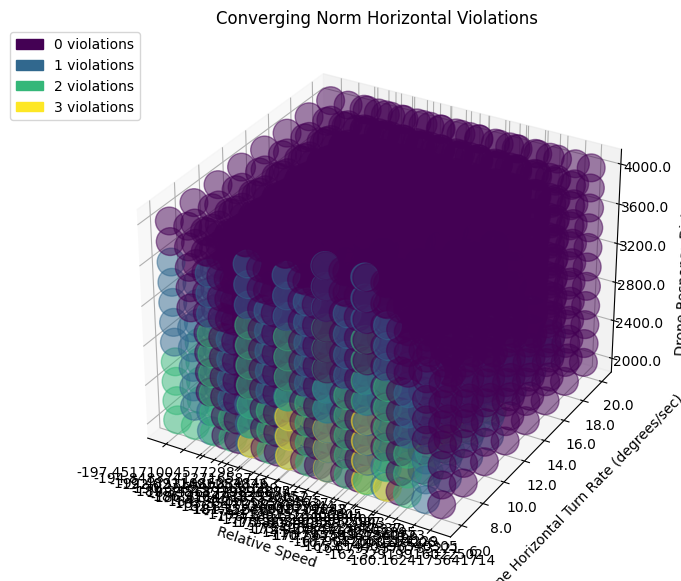

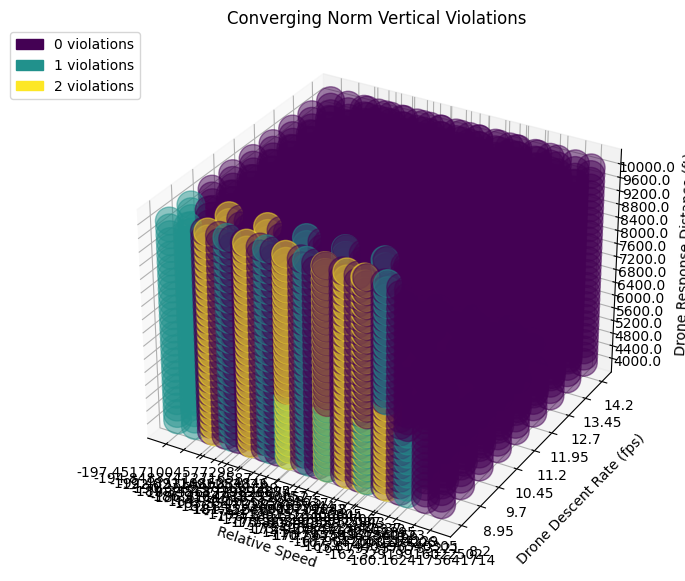

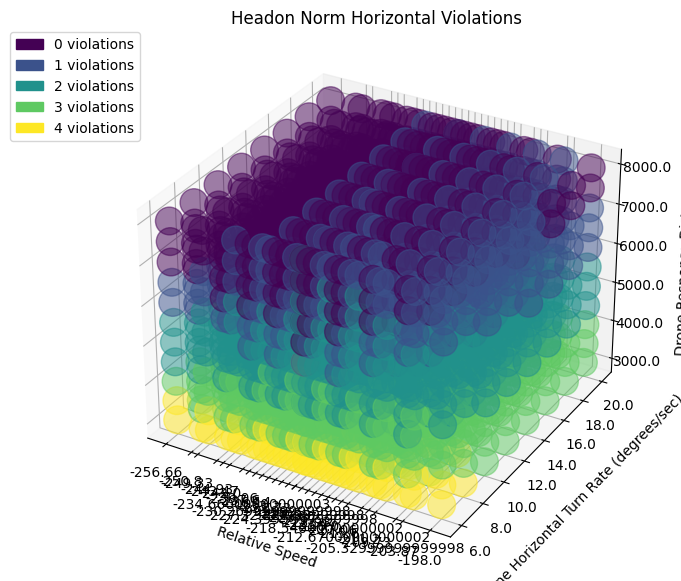

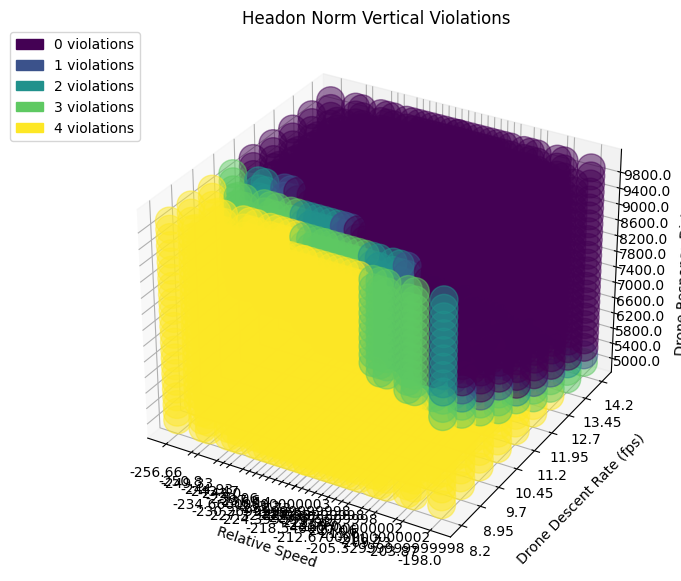

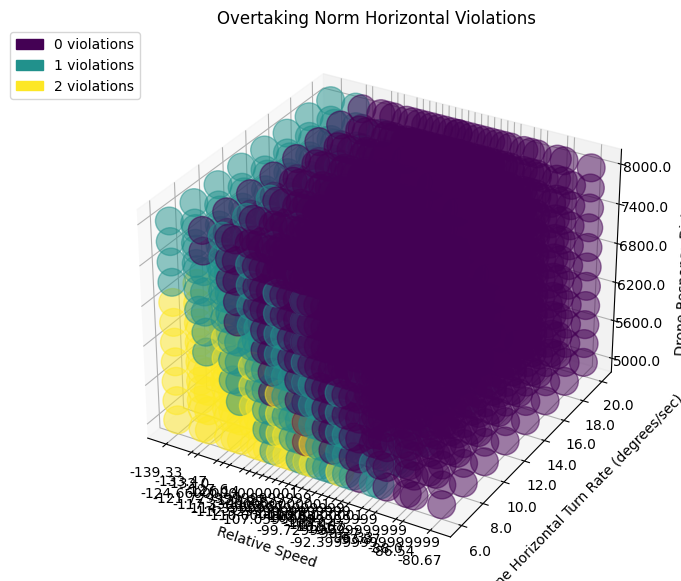

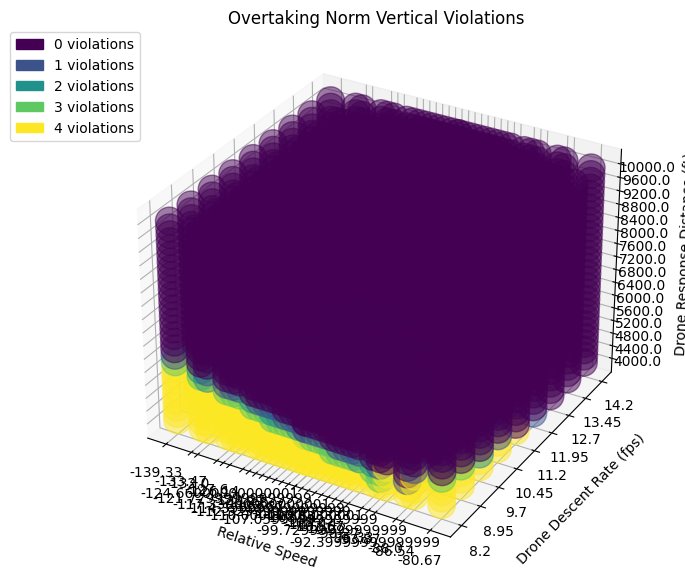

In [14]:
conversions = {
    "drone_speed": ("mph", "fps"),
    "heli_speed": ("mph", "fps"),
    "drone_response_distance": ("ft", "ft"),
    "drone_horizontal_turn_rate": ("degrees/sec", "degrees/sec"),
}

for fn in os.listdir(PATH)[1:]:
    if "adverse" in fn:
        continue
    fn_noext = fn.split('.')[0]
    title = create_title(fn)
    print(title)
    
    df = pd.read_csv(f"{PATH}/{fn}")
    df = prepare(df, conversions)
    
    # calculating relative speed for map
    if "headon" in fn:
        calc_rel = lambda df: -(df['heli_speed'] + df['drone_speed'])
    elif "converging" in fn:
        calc_rel = lambda df: -(df['heli_speed']**2 + df['drone_speed']**2)**0.5
    else:
        calc_rel = lambda df: df['drone_speed'] - df['heli_speed']
        
    df['relative_speed'] = calc_rel(df)
    
    df.describe().to_csv(f"tables/{fn_noext}-description.csv")
    
    axes = get_relevant_axes(fn)
    axes_titles = {
        **{axis: ' '.join(title_case(axis.split('_'))) for axis in axes},
        **{axis: f"{' '.join(title_case(axis.split('_')))} ({conv[1]})" for axis, conv in conversions.items()}
    }
    
    if "drone_ascent_rate" in axes:
        axes_titles["drone_ascent_rate"] = "Drone Descent Rate (fps)"
        df["drone_ascent_rate"] = -df["drone_ascent_rate"]
    
    print("axes titles:", axes_titles)
    print("axes:", axes)
    # violations = isolate(df, {"is_violation": 1})    
    violations = df.groupby(list(axes), as_index=False).agg({
        "is_violation": "sum",
    })
    
    plot_point_cloud(violations, *axes, title=title, point_radius=20, axes_titles=axes_titles, use_values_as_ticks=True, tick_skip=(0,0,1))
    # plt.show()
    plt.savefig(f"figures/{fn}-rel_speed-3dplot.png")

    # find all safe combinations of drone params    
    # safe = isolate(
    #     df.groupby(list(axes), as_index=False).agg(
    #         is_violation=("is_violation", "sum"),
    #         max_heli_speed=("heli_speed", "max"),
    #         min_heli_speed=("heli_speed", "min"),
    #     # df.groupby(list(axes), as_index=False).agg({
    #     #     "is_violation": "sum",
    #     #     "heli_speed": ["min", "max"]
    #     # }
    # ), {"is_violation": 0})
    # safe.to_csv(f"tables/{fn_noext}-safe.csv")
    
    safe_map = isolate(df, {"is_violation": 0}).groupby([*axes[0:2]]).min("drone_response_distance")
    
    safe_map.to_csv(f"tables/{fn_noext}-map.csv")
        
    
    
    
    
None    
    

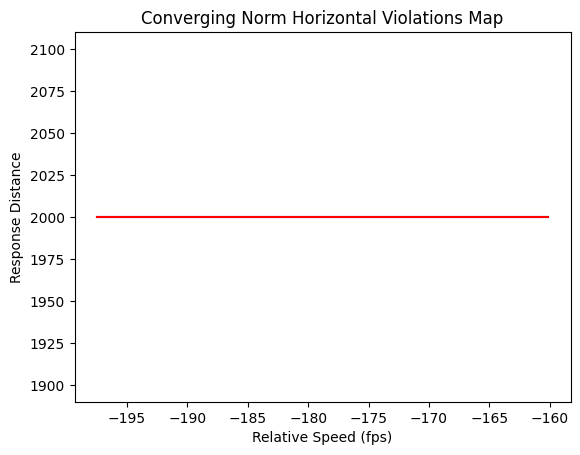

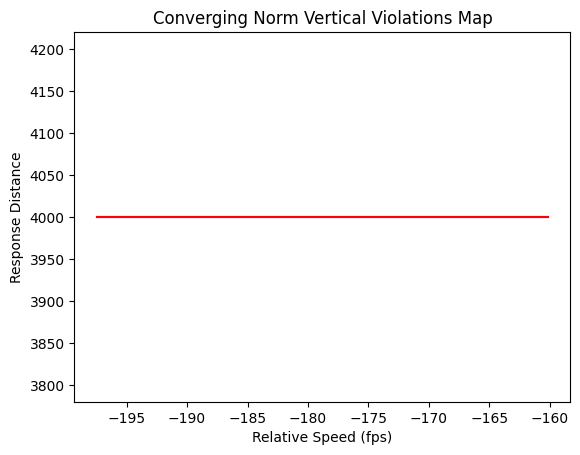

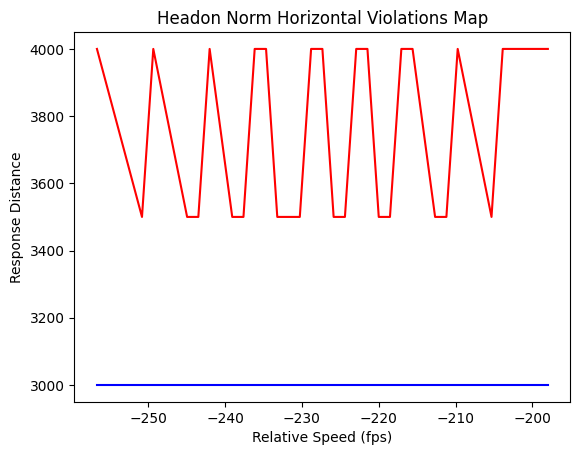

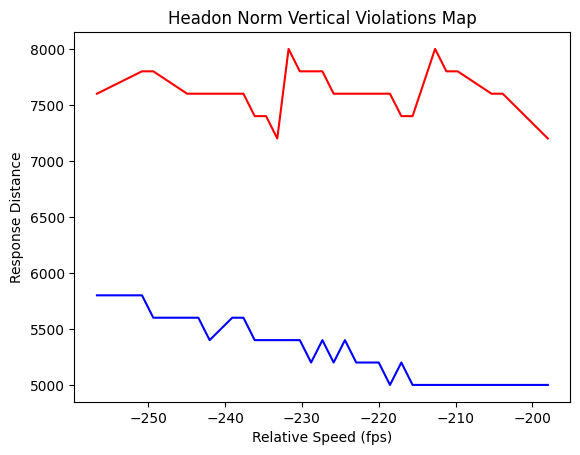

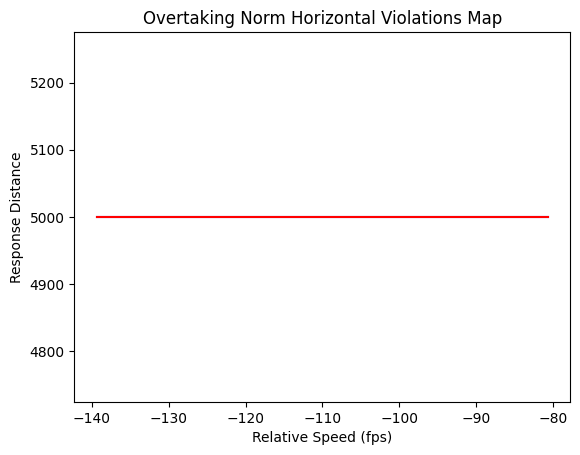

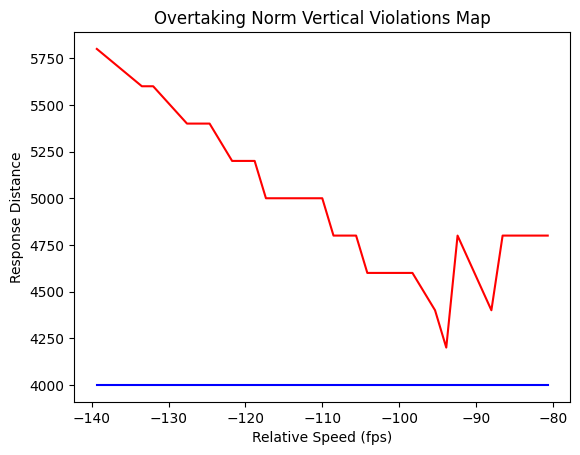

In [21]:
for fn in os.listdir("tables"):
    if "-map" not in fn:
        continue 
    
    df = pd.read_csv(f"tables/{fn}")
    df.sort_values("relative_speed")
    
    x = df.relative_speed.unique()
    
    y_min = df.groupby(df.relative_speed).min("drone_response_distance").drone_response_distance
    y_max = df.groupby(df.relative_speed).max("drone_response_distance").drone_response_distance
    
    fig, ax = plt.subplots()
    
    ax.plot(x, y_min, color="blue")
    ax.plot(x, y_max, color="red")
    
    ax.set_title(" ".join(title_case(fn.split('.')[0].split('-'))))
    ax.set_ylabel("Response Distance")
    ax.set_xlabel("Relative Speed (fps)")
    
    plt.show()
    

In [33]:
def nearest_idx(arr: np.ndarray, value: float):
    idx = np.absolute(arr - value).argmin()
    return idx
    # return df.iloc[(df[key]-value).abs().argsort()[:1]]
# def nearest(df: DataFrame, key: str, value: float):
#     return df.iloc[(df[key]-value).abs().argsort()[:1]]

In [35]:
# a = DataFrame({
#     'a': [1,2,3,4,5.5, 6, 1, 8, 8.2, 5.9, 5.3],
#     'b': [1,2,3,4,5.5, 6, 1, 8, 8.2, 5.9, 5.3]
# })

a = np.array([1,2,3,4,5.5, 6, 1, 8, 8.2, 5.9, 5.3])
a[nearest_idx(a, 5.8)]

5.9

In [44]:
# maximum minimum distance 
# ideal case 
#   heli 115.1 mph, drone 34.0 mph
#   turn rate of 13.89 degrees/s
#   descent rate of (default) 8.2fps to (max) 26.25fps

h_speed = 115.1 * 1.46667
d_speed = 34.0 * 1.46667
turn_rate = 13.89
descent_rate = 8.2
descent_rate_max = 26.25


for fn in os.listdir("tables"):
    if "-safe" not in fn or "adverse" in fn:
        continue 
    
    print("-"*15)
    print(" ".join(title_case(fn.split('.')[0].split('-'))))
    
    df = pd.read_csv(f"tables/{fn}")
    print(df.columns)
    
    max_rd = df.drone_response_distance.max()
    
    print(f"Worst case scenario response distance: {max_rd}.")
    
    
    
    if "horizontal" in fn:
        ds = df.drone_speed.unique()
        dh = df.heli_speed.unique()
        tr = df.drone_horizontal_turn_rate.unique()
        
        actual_ds = ds[nearest_idx(ds, h_speed)]
        actual_hs = dh[nearest_idx(dh, d_speed)]
        actual_tr = tr[nearest_idx(tr, turn_rate)]
        
        # it's written as ascent when it should be descent fyi
        # lo_dr = get_close_val(df, "drone_ascent_rate", descent_rate)
        # hi_dr = get_close_val(df, "drone_ascent_rate", descent_rate_max)
        
        print(f"Target drone speed, heli speed, turn rate, descent rate min, and descent rate max.")
        print(
            h_speed,
            d_speed,
            turn_rate,
            # descent_rate,
            # descent_rate_max,
        )
        print("actual")
        print(
            actual_ds,
            actual_hs,
            actual_tr,
            # lo_dr,
            # hi_dr,
        )
        print("% error")
        print(
            round((actual_ds - h_speed) / h_speed * 100, 2),
            round((actual_hs - d_speed) / d_speed * 100, 2),
            round((actual_tr - turn_rate) / turn_rate * 100, 2),
            # round((lo_dr - descent_rate) / descent_rate * 100, 2),
            # round((hi_dr - descent_rate_max) / descent_rate_max * 100, 2),
            sep="%, "
        )
        
        ideal_rd = df[
            (df.drone_speed == actual_ds) &
            (df.heli_speed == actual_hs) &
            (df.drone_horizontal_turn_rate == actual_tr)
            # (df.drone_ascent_rate == lo_dr)
        ]
        # ideal_rd_hi = df[
        #     (df.drone_speed == actual_ds) &
        #     (df.heli_speed == actual_hs) &
        #     (df.drone_horizontal_turn_rate == actual_tr)
        #     # (df.drone_ascent_rate == hi_dr)
        # ]
        print(f"Response distance: {ideal_rd}")
        
    else:
        print("Skipping vertical") 
    
    print("\n\n")
    
    

---------------
Converging Norm Horizontal Violations Safe
Index(['Unnamed: 0', 'drone_speed', 'drone_horizontal_turn_rate',
       'drone_response_distance', 'is_violation', 'max_heli_speed',
       'min_heli_speed'],
      dtype='object')
Worst case scenario response distance: 4000.0.


AttributeError: 'DataFrame' object has no attribute 'heli_speed'

In [ ]:
# maximum minimum distance 
# ideal case 
#   heli 115.1 mph, drone 34.0 mph
#   turn rate of 13.89 degrees/s
#   descent rate of (default) 8.2fps to (max) 26.25fps

h_speed = 115.1 * 1.46667
d_speed = 34.0 * 1.46667
turn_rate = 13.89
descent_rate = 8.2
descent_rate_max = 26.25


for fn in os.listdir("tables"):
    if "-safe" not in fn:
        continue 
    
    print("-"*15)
    print(" ".join(title_case(fn.split('.')[0].split('-'))))
    
    df = pd.read_csv(f"tables/{fn}")
    df.sort_values("relative_speed")
    
    x = df.relative_speed.unique()
    
    max_rd = df.groupby(df.relative_speed).max("drone_response_distance").drone_response_distance.max()
    
    print("\n\n")
    
    